In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/gemma-rewrite-nbroad/nbroad-v2.csv
/kaggle/input/gemma-rewrite-nbroad/nbroad-v1.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import re
from wordcloud import WordCloud

2024-03-15 07:22:30.428065: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-15 07:22:30.428204: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-15 07:22:30.593543: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
df_v1 = pd.read_csv('/kaggle/input/gemma-rewrite-nbroad/nbroad-v1.csv')

In [4]:
df_v2 = pd.read_csv('/kaggle/input/gemma-rewrite-nbroad/nbroad-v2.csv')

In [10]:
df_v1.head(10)

,id,original_text,rewrite_prompt,rewritten_text
0,LNpAovroGe,"This quilt, that my mother made, \n \n Still m...",Regency Romance: Model the text on a Regency r...,"The softest brown and brightest blue quilt, cr..."
1,nnuxwwThWi,It's the job of our agency to keep track of th...,Write like Ernest Hemingway: Focus on Hemingwa...,The agency's responsibility is to track and co...
2,aYmnFCsjKl,"The first punch gets me right in the ribs, kno...",Grimm's Fairy Tales: Adapt the text to mimic t...,"In the sweltering sun, the stench of sweat and..."
3,ufIVkreRND,Some nights I lay awake staring at the ceiling...,High Fantasy Epic: Transform the essay into a ...,In the tapestry of the ethereal realm of Eldri...
4,XwLNuYdDdE,"I can hardly read the letter, because the hand...",Fairy Tale Villain: Use the menacing and craft...,"My hand quivered as I clutched the letter, the..."
5,efQfmZRLZp,`` They do n't believe we're interesting?'' on...,"Beat Generation: Channel the spontaneous, free...",The mermaids' council deliberated on the dwind...
6,IFOAXxDebP,Not a single person in the crowd of Nora Janic...,"Fantasy Dwarf: Write with the gruff, hearty st...",The crowd at Nora Janice's funeral was silent ...
7,fdEeUgBHtL,`` Brigands and cutpurses have nothing on me. ...,"Drunkard: Infuse the essay with the rambling, ...","""Swerry brutes and cutthroat cutpurse, they ai..."
8,VJTFYkuxcQ,Sergeant Clark lifted his wrist to look at the...,High Fantasy Epic: Transform the essay into a ...,The scent of ash and molten earth hung heavy i...
9,ASfinLiPvt,I never thought working with CPS would be easy...,Renaissance Scholar: Emulate the writing of a ...,My musings on the arduous nature of social ser...


In [14]:
df_v2.head(10)

,id,original_text,rewrite_prompt,rewritten_text
0,lZGdiueMer,"`` Well, there are healthier ways to tell me y...",Rewrite the story where the writer asks the re...,"Well, there are healthier ways to tell me you ..."
1,DfTJVFKrUk,Rory ran his shaky fingers through his wife's ...,Rewrite the essay as a dramatic play,## The Final Curtain\n\n[FADE IN]\n\n**Setting...
2,LmJvKranXK,As I made my way on foot across town to the Po...,Rewrite the story with all the themes and sett...,As I made my way through the Tatooine desert o...
3,PpnqXQAdGH,`` Hello. We come in peace.'' \n \n The first ...,Rewrite the essay if the advanced aliens didn'...,`` Hello. We come in peace.''\n\nThe first enc...
4,qOeXTfqgAM,"`` Karen, what the helllllll izzz...'' says my...",Rewrite the story as a court room drama starri...,The courtroom erupted in an uproar as District...
5,RmbMlFHQJD,"I think about us sometimes, you know? \n \n Us...",Rewrite the narrative from the perspective of ...,"I am an old ship, worn down and forgotten. I o..."
6,rwVVvwffjW,The last scoop of sad ice cream tasted sweeter...,Rewrite the story as a psychological thriller ...,"In the cold confines of my solitary apartment,..."
7,tFbzieDrEn,There are so many people I want to write to in...,"Rewrite the essay, making it a sappy Hallmark ...","(Scene opens on a cozy, dimly lit living room)..."
8,jifAYXJXPe,Smells of old oak and fresh blood intermingled...,Rewrite the prompt as a fantasy version of the...,The scent of ancient incense and fresh blood m...
9,TBqnsiFsIH,Once upon a time there was a princess. \n \n T...,Rewrite the story as a dramatic musical in one...,## The Red Princess\n\n**Characters:**\n\n* Pr...


In [11]:
df_v1.tail(10)

,id,original_text,rewrite_prompt,rewritten_text
2156,eZTFxzkYwA,The metallic restraints are cold as ice. My ba...,Write like a Zen master: Use the minimalist an...,"In the stillness of the room, the metallic res..."
2157,REEQIhZTxV,There's a problem with being a shapeshifter. I...,Jane Austen's Regency Era: Transform the text ...,The silken threads of Regency England danced g...
2158,aganYJHkbZ,`` According to Federson Bioengineering v. Sta...,Disinterested Teen: Rewrite the text with the ...,"""According to some lawyer stuff, the plaintiff..."
2159,PlCumassCy,`` Not today Sin.'' \n \n The rooftop was quie...,Write like Jane Austen: Employ Austen's keen s...,"In the serene rooftop, bathed in an aura of tr..."
2160,FlXloUhoKU,"We destroyed the Earth, but we survived. Our g...",Write like Mark Twain: Use Twain's humorous an...,"We have destroyed the Earth, but we have survi..."
2161,dZpCXooaHn,"`` Nein, Nein, Die Englisch sind hier! Geoff i...",1950s American Suburbia: Recast the essay with...,The picket fences and shining chrome of 1950s ...
2162,FWONqGJidk,Trigger warning. \n \n \n -- - \n \n \n Every ...,Write like William Shakespeare: Write in Shake...,"Fair maiden, thy beauty doth beguile,\nWith ey..."
2163,TDCNripkkT,"Nobody understand candle. Candle is light, can...",Write like a Beat poet: Use the rhythmic and r...,"Candle, light in the darkness, life in the bel..."
2164,xulqOrwbms,**Cooper is back! ** \n \n Last year they left...,Space Explorer: Adopt the curious and hopeful ...,**Cooper's Journey**\n\nIn the vast expanse of...
2165,pEtQCTsZUf,Rowan collapsed on the steps of the church in ...,Write like J.K. Rowling: Craft the text in the...,"In the heart of a bustling street, where tower..."


In [15]:
df_v2.tail(10)

,id,original_text,rewrite_prompt,rewritten_text
2390,ofhbhEooFD,So many positive message stories. Let's get so...,Rewrite the story by using supervillains,So many positive message stories. Let's get so...
2391,manFgFlQWb,"Tim sat in the bunker, playing the umpteenth g...",Rewrite the essay as a sci-fi story set entire...,"Tim sat in the cramped bunker, playing the ump..."
2392,NEblAYKPPa,*INSPIRED BY A REAL LIFE EVENT* \n \n `` I rem...,Rewrite it as a poem,"In the realm of imagination, where dreams take..."
2393,NBmaVPJvzz,"*Dear Alexandra, * \n \n *How have you been? E...",Rewrite the story to have the character say th...,"*Dear Alexandra, * \n \n *How have you been? E..."
2394,TcJYVmgHvK,It was a clash of wills. That was the best way...,Rewrite the essay as a thrilling adventure wit...,"It was a match of wits and blades, a dance of ..."
2395,ljSaWTXjFc,"`` Dave, have you seen this?'' There is no ans...",Rewrite this as a Shakespearean tragedy,"Alas, poor Dave, a victim of fate's cruel hand..."
2396,nwZeXhsofO,"I posted something like this a while ago, I gu...",Rewrite the story as if you are a famous celeb...,"I'm the epitome of stardom, yet I can't shake ..."
2397,ozaryEVFvK,"`` Oh Darling, it was absolutely dreadful!'' M...",Rewrite the story as an upbeat mystery story (...,"Hey folks, buckle up for a mystery that will h..."
2398,WTvBtRNlQS,Ubwuwuaua! I exclaim shaking my head back and ...,Rewrite the story from the perspective of the ...,Ubwuwuaua. The whispers of the wind dance thro...
2399,jcLSWkFNKS,"`` Yeah I'll hook you up fam, how many?'' \n \...",Rewrite this story to focus on the moral dilem...,"The aroma of fresh pizza filled the air, but t..."


In [12]:
df_v1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2166 entries, 0 to 2165
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              2166 non-null   object
 1   original_text   2166 non-null   object
 2   rewrite_prompt  2166 non-null   object
 3   rewritten_text  2166 non-null   object
dtypes: object(4)
memory usage: 67.8+ KB


In [17]:
df_v2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2400 entries, 0 to 2399
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              2400 non-null   object
 1   original_text   2400 non-null   object
 2   rewrite_prompt  2400 non-null   object
 3   rewritten_text  2400 non-null   object
dtypes: object(4)
memory usage: 75.1+ KB


In [13]:
df_v1.describe()

,id,original_text,rewrite_prompt,rewritten_text
count,2166,2166,2166,2166
unique,2166,2166,109,2166
top,LNpAovroGe,"This quilt, that my mother made, \n \n Still m...",Write like a vintage radio announcer: Adopt th...,"The softest brown and brightest blue quilt, cr..."
freq,1,1,32,1


In [18]:
df_v2.describe()

,id,original_text,rewrite_prompt,rewritten_text
count,2400,2400,2400,2400
unique,2400,2400,2400,2400
top,lZGdiueMer,"`` Well, there are healthier ways to tell me y...",Rewrite the story where the writer asks the re...,"Well, there are healthier ways to tell me you ..."
freq,1,1,1,1


Convert Pandas Data to Numpy

In [5]:
data_v1 = df_v1.select_dtypes(include=[np.number]).to_numpy()
data_v2 = df_v2.select_dtypes(include=[np.number]).to_numpy()

In [6]:
print(data_v1.shape)
print(data_v2.shape)

(2166, 0)
(2400, 0)


Data Cleaning in Numpy

In [7]:
# Removing NaN values
data_v1 = np.nan_to_num(data_v1)
data_v2 = np.nan_to_num(data_v2)

In [8]:
data_v1

array([], shape=(2166, 0), dtype=float64)

In [9]:
data_v2

array([], shape=(2400, 0), dtype=float64)

Natural Language Processing (NLP)

In [23]:
# lowercasing

df_v1['original_text'] = df_v1['original_text'].str.lower()
df_v2['original_text'] = df_v2['original_text'].str.lower()

Removing Punctuation and Special Characters

In [24]:
df_v1['original_text'] = df_v1['original_text'].apply(lambda x: re.sub(r'\W+', ' ', x))
df_v2['original_text'] = df_v2['original_text'].apply(lambda x: re.sub(r'\W+', ' ', x))

In [25]:
df_v1

,id,original_text,rewrite_prompt,rewritten_text
0,LNpAovroGe,this quilt that my mother made still makes me ...,Regency Romance: Model the text on a Regency r...,"The softest brown and brightest blue quilt, cr..."
1,nnuxwwThWi,it s the job of our agency to keep track of th...,Write like Ernest Hemingway: Focus on Hemingwa...,The agency's responsibility is to track and co...
2,aYmnFCsjKl,the first punch gets me right in the ribs knoc...,Grimm's Fairy Tales: Adapt the text to mimic t...,"In the sweltering sun, the stench of sweat and..."
3,ufIVkreRND,some nights i lay awake staring at the ceiling...,High Fantasy Epic: Transform the essay into a ...,In the tapestry of the ethereal realm of Eldri...
4,XwLNuYdDdE,i can hardly read the letter because the hand ...,Fairy Tale Villain: Use the menacing and craft...,"My hand quivered as I clutched the letter, the..."
...,...,...,...,...
2161,dZpCXooaHn,nein nein die englisch sind hier geoff in dec...,1950s American Suburbia: Recast the essay with...,The picket fences and shining chrome of 1950s ...
2162,FWONqGJidk,trigger warning every day hurt she has her fat...,Write like William Shakespeare: Write in Shake...,"Fair maiden, thy beauty doth beguile,\nWith ey..."
2163,TDCNripkkT,nobody understand candle candle is light candl...,Write like a Beat poet: Use the rhythmic and r...,"Candle, light in the darkness, life in the bel..."
2164,xulqOrwbms,cooper is back last year they left earth now ...,Space Explorer: Adopt the curious and hopeful ...,**Cooper's Journey**\n\nIn the vast expanse of...


In [26]:
df_v2

,id,original_text,rewrite_prompt,rewritten_text
0,lZGdiueMer,well there are healthier ways to tell me you ...,Rewrite the story where the writer asks the re...,"Well, there are healthier ways to tell me you ..."
1,DfTJVFKrUk,rory ran his shaky fingers through his wife s ...,Rewrite the essay as a dramatic play,## The Final Curtain\n\n[FADE IN]\n\n**Setting...
2,LmJvKranXK,as i made my way on foot across town to the po...,Rewrite the story with all the themes and sett...,As I made my way through the Tatooine desert o...
3,PpnqXQAdGH,hello we come in peace the first encounter wa...,Rewrite the essay if the advanced aliens didn'...,`` Hello. We come in peace.''\n\nThe first enc...
4,qOeXTfqgAM,karen what the helllllll izzz says my boyfrie...,Rewrite the story as a court room drama starri...,The courtroom erupted in an uproar as District...
...,...,...,...,...
2395,ljSaWTXjFc,dave have you seen this there is no answer da...,Rewrite this as a Shakespearean tragedy,"Alas, poor Dave, a victim of fate's cruel hand..."
2396,nwZeXhsofO,i posted something like this a while ago i gue...,Rewrite the story as if you are a famous celeb...,"I'm the epitome of stardom, yet I can't shake ..."
2397,ozaryEVFvK,oh darling it was absolutely dreadful matilda...,Rewrite the story as an upbeat mystery story (...,"Hey folks, buckle up for a mystery that will h..."
2398,WTvBtRNlQS,ubwuwuaua i exclaim shaking my head back and f...,Rewrite the story from the perspective of the ...,Ubwuwuaua. The whispers of the wind dance thro...


Tokenization and Vectorizing the Text

In [28]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(pd.concat([df_v1['original_text'], df_v2['original_text']]))

sequences_v1 = tokenizer.texts_to_sequences(df_v1['original_text'])
sequences_v2 = tokenizer.texts_to_sequences(df_v2['original_text'])

# Padding sequences to ensure uniform input size
padded_v1 = pad_sequences(sequences_v1, maxlen=200)
padded_v2 = pad_sequences(sequences_v2, maxlen=200)

Create a model

In [34]:
model = Sequential([
    Dense(128, activation='relu', input_shape=(200,)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [35]:
model

<Sequential name=sequential_5, built=True>

Visualize word frequencies

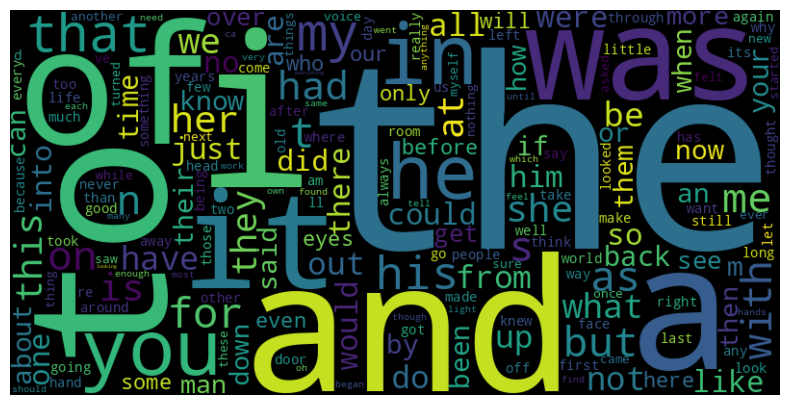

In [36]:
word_counts = tokenizer.word_counts
wordcloud = WordCloud(width=800, height=400).generate_from_frequencies(word_counts)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Comprehensive word cloud

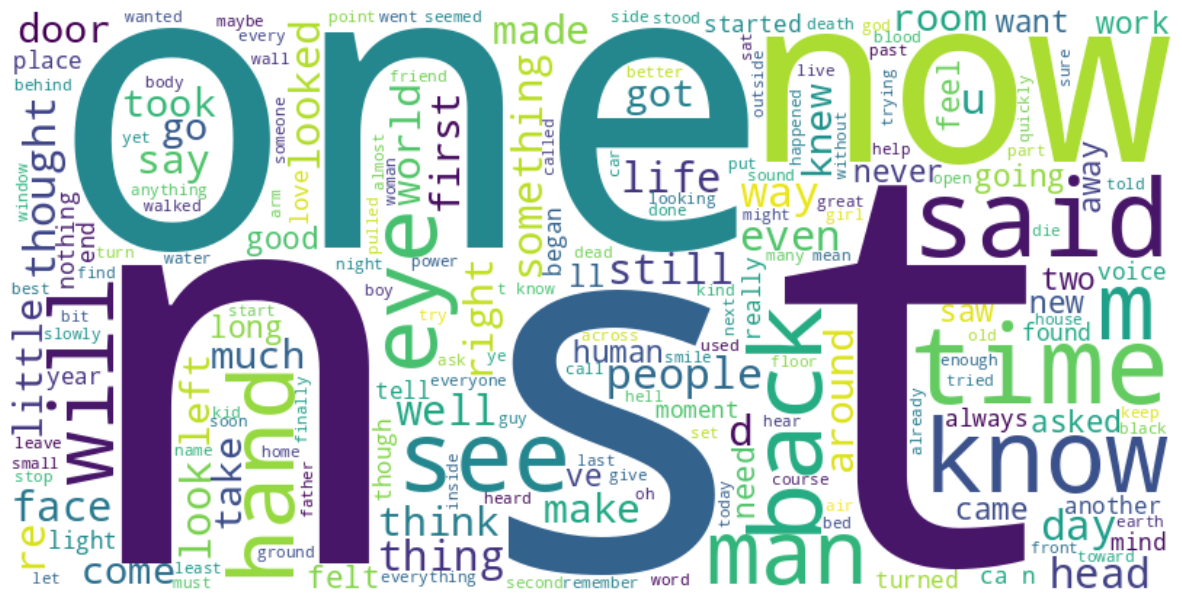

In [37]:
# Assuming df_v1['text_column'] and df_v2['text_column'] have been preprocessed
combined_texts = pd.concat([df_v1['original_text'], df_v2['original_text']])

# Generate a single text string for the word cloud
combined_text = " ".join(text for text in combined_texts)

# Create and display the word cloud
wordcloud = WordCloud(width=800, height=400, background_color ='white').generate(combined_text)

plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

General approach for a classification task using a text dataset and TensorFlow/Keras

In [52]:
print(df_v1.columns)

Index(['id', 'original_text', 'rewrite_prompt', 'rewritten_text'], dtype='object')


In [53]:
print(df_v2.columns)

Index(['id', 'original_text', 'rewrite_prompt', 'rewritten_text'], dtype='object')


use df_v1 to calculate value_counts()

In [101]:
# Value count for the 'rewrite_prompt' column in both datasets
value_counts_v1 = df_v1['rewrite_prompt'].value_counts()

In [103]:
value_counts_v1

rewrite_prompt
Write like a vintage radio announcer: Adopt the clear, enthusiastic style of a vintage radio announcer, full of charm.                                                     32
Write like a Broadway star: Embrace the expressive and dramatic style of a Broadway star, full of flair and emotion.                                                       32
Write like Stephen King: Adopt King's knack for storytelling, blending the ordinary with the supernatural in a compelling narrative.                                       29
Write like a reality TV star: Embrace the drama and over-the-top personality of a reality TV star.                                                                         28
Retro Futurist: Adopt the optimistic and imaginative tone of a retro futurist, envisioning a utopian future.                                                               28
                                                                                                                   

In [105]:
# Value count for the 'rewritten_text' column in both datasets
value_counts_v1 = df_v1['rewritten_text'].value_counts()

In [106]:
value_counts_v1

rewritten_text
the softest brown and brightest blue quilt crafted by the loving hand of a mother evokes vivid memories in my mind the curved stitch delicately etched upon its surface bears the inscription made it may a testament to the passage of time though the fabric may be veiled in mystery i firmly believe that this quilt is not merely a cloth but a treasured heirloom imbued with love and sentiment the intricate logo and signature meticulously woven into the quilt s fabric reveal the name bert a symbol of the owner s identity this precious artifact once a part of a stuffed bear holds a special place in my heart it was my mother s favorite a cherished relic from her youth gifted to her by her grandfather during a thanksgiving feast my father added his own touch to the quilt a pinned button that symbolized his mother s unwavering spirit and her dedication to scouting apparently she spent the entire night fishing in a store bin determined to teach her son about the profound emotion of

In [ ]:
# Using rewritten_text for prompt dalle gpt 4

the softest brown and brightest blue quilt crafted by the loving hand of a mother evokes vivid memories in my mind the curved stitch delicately etched upon its surface bears the inscription made it may a testament to the passage of time though the fabric may be veiled in mystery i firmly believe that this quilt is not merely a cloth but a treasured heirloom imbued with love and sentiment the intricate logo and signature meticulously woven into the quilt s fabric reveal the name bert a symbol of the owner s identity this precious artifact once a part of a stuffed bear holds a special place in my heart it was my mother s favorite a cherished relic from her youth gifted to her by her grandfather during a thanksgiving feast my father added his own touch to the quilt a pinned button that symbolized his mother s unwavering spirit and her dedication to scouting apparently she spent the entire night fishing in a store bin determined to teach her son about the profound emotion of love i regret that you had to witness this personal tragedy but i find solace in knowing that their funeral was delayed allowing for more precious memories to be made 


[](http://)

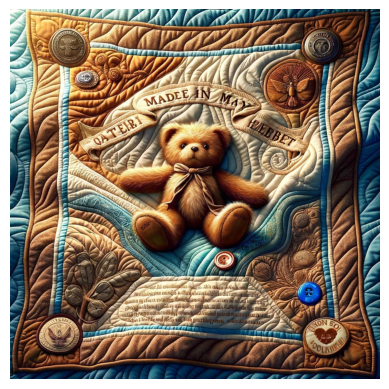

In [110]:
import matplotlib.pyplot as plt
from PIL import Image
import os

# Assuming you have a folder named 'dataset' containing your images in your Kaggle workspace
# Replace 'your_image.jpg' with the name of your image file
image_path = '/kaggle/input/using-gemma-rewrite-to-generate-photos-from-dalle/DALLE 2024-03-15 16.33.18 - Imagine a quilt that embodies a rich tapestry of family history and emotional depth. This quilt is soft brown and bright blue meticulously crafted wi.webp'

# Open and display the image
image = Image.open(image_path)
plt.imshow(image)
plt.axis('off') # Hide the axis
plt.show()

in the heart of a bustling street where towering gargoyles cast long shadows upon the unsuspecting rowan collapsed upon the steps of a venerable church the world around him stood still as if paused in a moment of profound silence the echoes of passing footsteps and the incessant hum of traffic faded into the background leaving only the somber melody of his fading breaths a symphony of indifference played out before his eyes people hurried to their destinations oblivious to his plight their eyes were glued to glowing screens immersed in virtual worlds oblivious to the real tragedy unfolding before their very eyes the stench of his decay mingled with the scent of the church but it was met with indifference as if he were a ghost rowan felt a presence gazing upon him a reflection of the apathy that consumed the world a passerby his senses piqued by an inexplicable sensation paused and looked at the dying man his gaze lingered and as he took a photograph the world erupted in a flurry of activity the image of rowan s distress was shared with the world accompanied by a caption that mocked his misfortune thousands of eyes feasted on the tragedy their reactions ranging from amusement to concern the digital realm became a petri dish for compassion as people expressed their solidarity through likes comments and virtual pats however in the midst of this digital compassion rowan s final breath escaped him carried away by the wind his soul entangled in the shackles of sin found no solace in the outpouring of virtual sympathy his death was a stark reminder of the fleeting nature of life and the profound impact it has on those left behind and so as the sun cast long shadows across the city streets the world continued to spin oblivious to the tragedy that had unfolded on the steps of that church the memory of rowan s demise faded into the collective consciousness yet it left an indelible mark on the hearts of those who witnessed it  




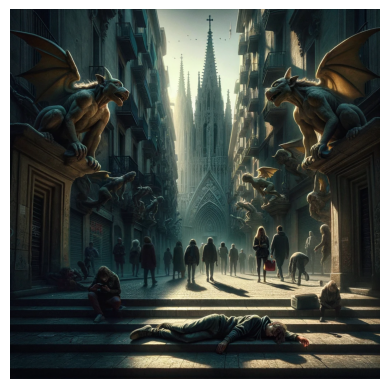

In [111]:
import matplotlib.pyplot as plt
from PIL import Image
import os

# Assuming you have a folder named 'dataset' containing your images in your Kaggle workspace
# Replace 'your_image.jpg' with the name of your image file
image_path = '/kaggle/input/using-gemma-rewrite-to-generate-photos-from-dalle/DALLE 2024-03-15 16.38.48 - In the heart of a bustling street shadowed by towering gargoyles a poignant scene unfolds. Rowan lies collapsed on the steps of an ancient church th.webp'

# Open and display the image
image = Image.open(image_path)
plt.imshow(image)
plt.axis('off') # Hide the axis
plt.show()

the scent of damp earth and ozone the sweet scent of the countryside all faded into the background hum of my consciousness as i sat in the sterile waiting room of the agency my son philip had gone to the country for a holiday and the world had erupted in a civil war my mind raced my stomach churned and i felt as if i was being squeezed in a vice the pressure unbearable i felt as if my very life was hanging precariously on a thread and the world below me was collapsing my phone rang and i knew it was bad news the agency had hired me to go in and get their vp but it was too late but i was going to save the others god didn t have my back on this one i hooked up with some rebels and got the blueprints for the enemy hostage warehouse after studying for several hours i made my move i was silent as the night a shadow in the darkness the warehouse erupted in a blaze of gunfire and i knew i was in the middle of a nightmare one after the other the hostages dropped dead their bodies disappearing into dark corners i grabbed the remaining hostages and made a run for it the sirens screamed and i felt as if the world was spinning out of control about 15 minutes into the break the sirens started and 5 minutes later they were on our trail we made a solid sprint to the border and i was loading the kids onto a truck when i got tagged bloody dying i uttered my final words fly you fools i pushed the truck away and fell into the mud my life ending in a silent scream the war had taken everything from me but i knew that i had done everything i could to protect my son my final act had been to save the lives of others even at the cost of my own    

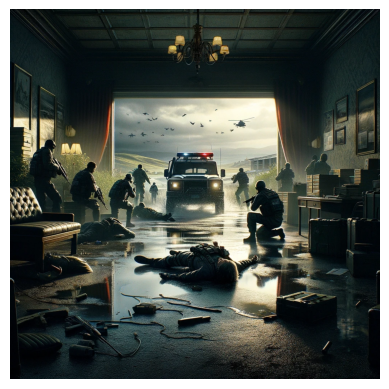

In [112]:
import matplotlib.pyplot as plt
from PIL import Image
import os

# Assuming you have a folder named 'dataset' containing your images in your Kaggle workspace
# Replace 'your_image.jpg' with the name of your image file
image_path = '/kaggle/input/using-gemma-rewrite-to-generate-photos-from-dalle/DALLE 2024-03-15 16.40.21 - Envision a tense dramatic scene set against the backdrop of a civil war. The protagonist in a sterile agency waiting room reminisces about the sere.webp'

# Open and display the image
image = Image.open(image_path)
plt.imshow(image)
plt.axis('off') # Hide the axis
plt.show()